In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
# import string
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import date
from datetime import datetime
from sklearn.preprocessing import StandardScaler,Imputer,RobustScaler

In [2]:
listings_Boston = pd.read_csv("listings_Boston.csv")
listings_Seattle = pd.read_csv("listings_Seattle.csv")
cb = pd.read_csv("calendar_Boston.csv")
cs = pd.read_csv("calendar_Seattle.csv")
rb = pd.read_csv("reviews_Boston.csv")
rs = pd.read_csv("reviews_Seattle.csv")

In [3]:
def preprocessing(listing):
    null_count = listing.isnull().sum()
#     print(null_count.sort_values(ascending=False))

    null_per = null_count / len(listing) * 100
#     print(null_per.sort_values(ascending=False))

    drop_index = null_per[null_per > 50].index
    listing.drop(drop_index, axis = 1, inplace = True)
    plt.figure(figsize=(15,5))
    plt.title('Distribution of the Ratio of Missing Data in Each Column')
    plt.hist(null_per, bins = np.linspace(10,100,50))
    plt.xlabel('Percentage of Missing Data')
    plt.ylabel('Count')
    plt.show()

#     d={}
#     for col in listing.columns:
#         data_type = listing[col].dtype
#         if data_type not in d:
#             d[data_type] = 1
#         else:
#             d[data_type] += 1

#     print(d)

    if type(listing.price[0]) == str:
        listing.price = listing.price.apply(lambda x: float(x[1:].replace(',', '')))
#         print(listing.price.describe())

    drop_price_index = listing[listing.price > 500].index
    listing.drop(drop_price_index, axis = 0, inplace = True)
    listing.drop(['space', 'neighborhood_overview', 'transit','listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
                  'description', 'experiences_offered', 'picture_url', 'host_url', 'host_name', 'host_thumbnail_url',
                  'host_about', 'host_neighbourhood','host_picture_url', 'host_location', 'street', 'city', 'state', 
                  'smart_location', 'country_code', 'country', 'first_review', 'last_review', 'id', 'host_verifications',
                  'host_id', 'neighbourhood', 'calendar_last_scraped', 'market'], axis = 1, inplace = True)

    process_list = listing
    amenities = process_list['amenities'].map(lambda d: [amenity.replace('"', "").replace("{", "").replace("}", "") for amenity in d.split(",")])
    process_list['amenities'] = amenities
    possible_amenities = set([item for sublist in amenities for item in sublist])
    possible_amenities = list(possible_amenities)
    del possible_amenities[1]
    print("There are {} amenities in total.".format(len(possible_amenities)))
    mlb = MultiLabelBinarizer()
    amenities_result = pd.DataFrame(mlb.fit_transform(process_list['amenities']),columns=mlb.classes_, index=process_list.index)
    process_list2 = pd.concat([process_list, amenities_result], axis=1, sort = False)
    process_list2.drop(['amenities'], axis = 1, inplace = True)
    
    # Preprocess some other columns, convert into numerical value
    process_list2['cleaning_fee'] = process_list2['cleaning_fee'].replace( '[$,]','', regex=True ).astype(float)
    process_list2['extra_people'] = process_list2['extra_people'].replace( '[$,]','', regex=True ).astype(float)
    process_list2['host_response_rate'] = process_list2['host_response_rate'].replace( '%','', regex=True ).astype(float)


    # Fill missing data
    process_list2.bathrooms.fillna(process_list2.groupby("bedrooms")["bathrooms"].transform("median"), inplace=True)
    process_list2.beds.fillna(process_list2.groupby("bedrooms")["beds"].transform("median"), inplace=True)
    process_list2.bedrooms.fillna(process_list2.groupby("bathrooms")["bedrooms"].transform("median"), inplace=True)
    process_list2.cleaning_fee.fillna(0, inplace = True)
    fillmean_list = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                     'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

    for col in fillmean_list:
        process_list2[col].fillna(process_list[col].mean(), inplace = True)
    process_list2['host_response_rate'].fillna(process_list2.host_response_rate.mean(), inplace = True)   
    process_list2.zipcode.fillna(listing.groupby('neighbourhood_cleansed')['zipcode'].apply(
        lambda x: x.fillna(x.value_counts().index[0])), inplace = True)

    # One-hot encoding the whole dataframe
    process_list2 = pd.get_dummies(process_list2)
    price_raw = process_list2['price']
    process_list2 = process_list2.drop('price', axis = 1)

     # Use MinMax to process some of the numerical data
    scaler = MinMaxScaler()
    numerical = ['latitude', 'longitude', 'review_scores_rating']
    process_list2[numerical] = scaler.fit_transform(process_list2[numerical])

    return process_list2, price_raw, possible_amenities

In [4]:
def training(df, price, amenities):
#     df= pd.DataFrame(process_list2)
#     price=price_raw
#     amenities=possible_amenities
#     print(df.shape)
#     print(price.shape)
    X_train, X_test, y_train, y_test = train_test_split(df, price, test_size = 0.2, random_state = 0)
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    param_grid = {'n_estimators': [400], 
                      'learning_rate': [0.05],
                      'max_depth': [10],
                      'min_samples_split': [5],
                      'subsample': [0.7]
                     }
    forest_reg = GradientBoostingRegressor(random_state = 42)
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)
    y_pred = grid_search.predict(X_test)
    print("Error Score on Test Data: {}.".format(np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred))))
    # Plot Featrue Importance
    feature_importances = grid_search.best_estimator_.feature_importances_
    features = sorted(zip(feature_importances, df.columns), reverse=True)
    attribute = []
    coefficient = []
    for feature in features:
        attribute.append(feature[1]) 
        coefficient.append(feature[0])
    plt.figure(figsize=(12,4))
    plt.bar(attribute[:20], height=coefficient[:20])
    plt.xticks(rotation=90)
    plt.xlabel('feature')
    plt.ylabel('feature importance')
    plt.title('feature importance for the Top 20 features')
    plt.show()

    # Plot Amenity importance
    amenity= []
    amn_coef = []
    for feature in features:
        if feature[1] in amenities:
            amenity.append(feature[1])
            amn_coef.append(feature[0])
    plt.figure(figsize=(8,4))
    plt.bar(amenity[:10], height=amn_coef[:10])
    plt.xticks(rotation = 90)
    plt.xlabel('amenity')
    plt.ylabel('amenity importance')
    plt.title('feature importance for the Top 10 amenities')
    plt.show()

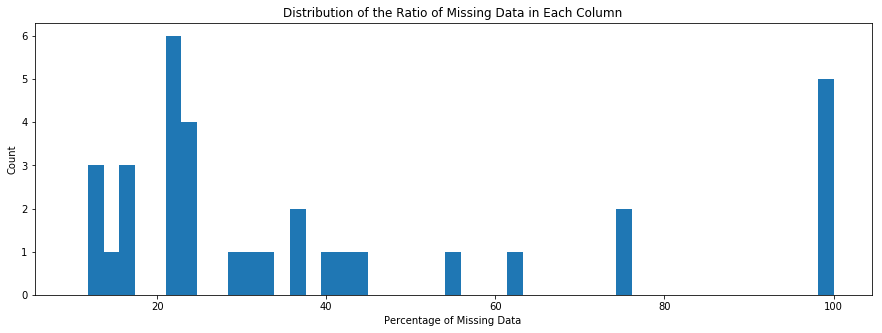

There are 45 amenities in total.


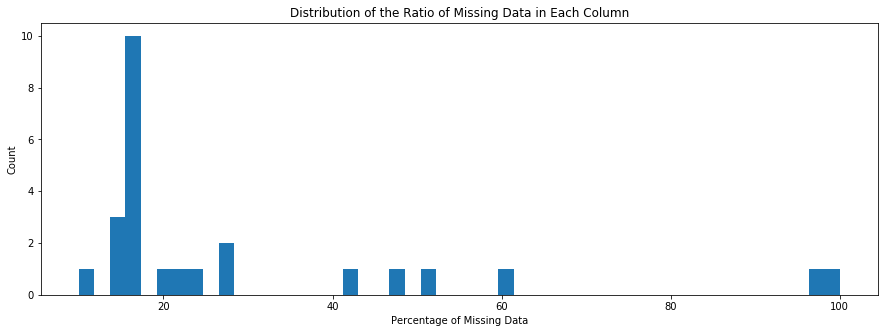

There are 41 amenities in total.


In [5]:
Boston, price_Boston, possible_amenities_Boston = preprocessing(listings_Boston)
Seattle, dprice_Seattle, possible_amenities_Seattle = preprocessing(listings_Seattle)

In [ ]:
training(Boston, price_Boston, possible_amenities_Boston)
training(Seattle, price_Seattle, possible_amenities_Seattle)

Training set has 2815 samples.
Testing set has 704 samples.
